# Splines

___

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

### Problem 1
Write a code to compute a natural spline $S(x)$ which interpolates a collection of
given points $(x_0, y_0),(x_1, y_1), \dots, (x_n, y_n)$ where $x_0 < x_1 < x_2 < \dots < x_n$ (do not
assume they are equidistributed). Your code should have a triadiagonal solver for the
resulting linear system of equations (you’re not allowed to use Matlab’s \ operator
to solve the linear system).

##### Solution

Firstly we define the function that calculates the distances between given points, aka the $h_j$.

In [2]:
def getHValues(X,n):
    H = np.array([X[i + 1] - X[i] for i in range(n)])
    return H

Next we calculate the solutions of the linear system, aka the $d_j$

In [3]:
def LinearSystem(H,F,n):
    D = np.array(
        [(-6/H[i])*(F[i+1]-F[i]) + (6/H[i+1])*(F[i+2]-F[i+1]) for i in range(n-1)]
    )
    return D

Then we create the tridiagonal matrix from $h_j$ values

In [4]:
def TriDiagMatrix(H, n):
    n = len(H)
    M = np.zeros((n-1,n-1))
    for i in range(n-1):
        for j in range(n-1):
            if j == i:
                M[i,j] = 2*(H[i] + H[i + 1])
            elif i == j - 1:
                M[i,j] = H[j]
            elif i == j + 1:
                M[i,j] = H[j]
    return M

And we create a solver for the given tridiagonal matrix from the algorithm in the classn notes.

In [5]:
def TriDiagSolver(M, D):
    b = np.diag(M, k = 1)
    a = np.diag(M, k = 0)
    c = np.diag(M, k = -1)
    
    N = len(a)
    m = np.zeros(N)
    l = np.zeros(N)
    y = np.zeros(N)
    x = np.zeros(N)
    
    m[0] = a[0]
    for j in range(N-1):
        l[j] = c[j]/m[j]
        m[j+1] = a[j+1]-(l[j]*b[j])
    
    y[0] = D[0]
    for i in range(1, N):
        y[i] = D[i]-(l[i-1]*y[i-1])
    
    x[-1] = y[-1]/m[-1]
    for k in reversed(range(N-1)):
        x[k] = (y[k]-(b[k]*x[k+1]))/m[k]
        
    x = np.append(0,x)
    x = np.append(x,0)
    return x

Now we find the coefficients for the Cubic Spline Funcion

In [6]:
def FindSplineCoeffs(z,h,f,n):
    A = np.array([(1/(6*h[i]))*(z[i+1]-z[i]) for i in range(n)])
    B = np.array([(1/2)*z[i] for i in range(n)])
    C = np.array(
        [(1/h[i])*(f[i+1] - f[i]) - (1/6)*h[i]*(z[i+1] + 2*z[i]) for i in range(n)]
    )
    D = np.array([f[i] for i in range(n)])
    return (A, B, C, D)

And now we create the function that calculates the spline at the given node.

In [7]:
def Spline(node, X, A, B, C, D):
    S = 0
    n = len(X)
    for j in range(0,n-1):
        if X[j] <= node <= X[j+1]:
            S = A[j]*(node-X[j])**3 + B[j]*(node-X[j])**2 + C[j]*(node-X[j]) + D[j]
    return S

___

### Problem 2

##### Solution
Below we interpolate the data given in the problem with our code, and a natural cubic spline. Then plot the curve, and then we print out the coefficients of the spline.

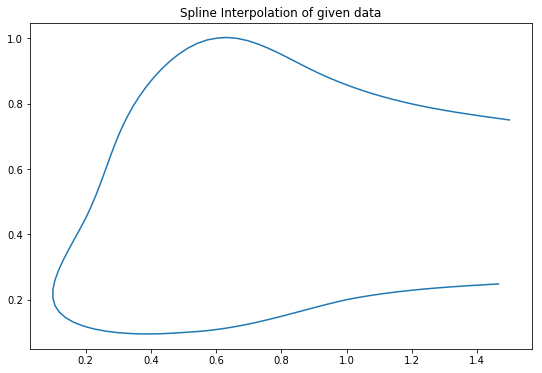

In [9]:
# The Given Data
t_j = [0, 0.618, 0.935, 1.255, 1.636, 1.905, 2.317, 2.827, 3.33]
x_j = [1.5, 0.9, 0.6, 0.35, 0.2, 0.1, 0.5, 1, 1.5]
y_j = [0.75, 0.9, 1, 0.8, 0.45, 0.2, 0.1, 0.2, 0.25]

# Length
n = len(y_j) - 1

# Distance between parameterized intervals
H = getHValues(t_j,n)

# The first derivatives at each point
dx = LinearSystem(H, x_j, n) 
dy = LinearSystem(H, y_j, n)

# Creating the tri diagonal matrix
A = TriDiagMatrix(H, n)

# The values of t, x(t) are plotted within or tridiagonal solver
z_x = TriDiagSolver(A, dx)
a_x,b_x,c_x,d_x = FindSplineCoeffs(z_x,H,x_j,n)

# The values of t, y(t) are plotted within or tridiagonal solver
z_y = TriDiagSolver(A, dy)
a_y, b_y, c_y, d_y= FindSplineCoeffs(z_y, H, y_j, n)

# t values to plot at
n_t = 100
time = np.array([i*(3.330/n_t) for i in range(n_t)])

# X spline
S_x = np.array([Spline(t, t_j, a_x, b_x, c_x, d_x) for t in time])
    
# Y Spline
S_y = np.array([Spline(t, t_j, a_y, b_y, c_y, d_y) for t in time])

# Plotting
plt.figure(figsize=(9,6))
plt.title("Spline Interpolation of given data")
plt.plot(S_x, S_y);

The coefficients for the X Spline:

In [10]:
x_coeffs = pd.DataFrame(data = {"A":a_x,"B":b_x,"C":c_x,"D":d_x})
x_coeffs

,A,B,C,D
0,0.010604,0.000000,-0.974924,1.50
1,0.101198,0.019660,-0.962774,0.90
2,0.971593,0.115899,-0.917829,0.60
3,-1.707982,1.048629,-0.545296,0.35
4,5.288485,-0.903595,-0.511360,0.20
5,-3.134092,3.364212,0.116812,0.10
6,0.413950,-0.509526,1.132582,0.50
7,-0.082053,0.123818,0.952515,1.00


The coefficients for the Y spline:

In [11]:
y_coeffs = pd.DataFrame(data = {"A":a_y,"B":b_y,"C":c_y,"D":d_y})
y_coeffs

,A,B,C,D
0,0.289737,0.000000,0.132061,0.75
1,-3.173081,0.537172,0.464033,0.90
2,2.605653,-2.480428,-0.098082,1.00
3,-0.303232,0.021000,-0.882619,0.80
4,2.174006,-0.325595,-0.999096,0.45
5,-0.688765,1.428828,-0.714482,0.20
6,-0.547783,0.577515,0.044024,0.10
7,0.172692,-0.260593,0.186789,0.20
